<a href="https://colab.research.google.com/github/milad-s5/DL_HW3_RNN/blob/2/2_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import math
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
# picture
from skimage.util import random_noise
import cv2

# Def functions

In [ ]:
def ocilator_gen(functype, cycles, period, phase, resolution, plot=True):
    t = np.linspace(0, cycles * period, resolution)
    phase = phase * np.pi
    internal = 2 * np.pi / period * t + phase

    if functype in ['sin', 'Sin']:
        ocil = np.sin(internal)
    elif functype in ['tri']:
        ocil = signal.sawtooth(internal, 0.5)
    elif functype in ['saw']:
        ocil = signal.sawtooth(internal)
    if plot==True:
      plt.plot(t, ocil)
      plt.xlabel('t')
      plt.ylabel(functype)
      plt.title(functype)
      plt.show()
    return t, ocil

In [ ]:
def snr_f(segment, noise, f_samp, f_max=2048):

    N = len(segment)        # number of points in time series
    T = 1.0 / f_samp        # sample spacing
    x_f = np.fft.fftfreq(N, T)                        
    frequencies = x_f[0:N//2]     # only positive frequencies
    h = segment-noise       # signal, obtained removing noise from segment

    segment_f = scipy.fftpack.fft(segment)[0:N//2]   # segment fft only positive f
    noise_f = scipy.fftpack.fft(noise)[0:N//2]       # noise fft
    h_f = scipy.fftpack.fft(h)[0:N//2]               # signal fft

    h_f =  h_f[np.where(frequencies<=f_max)]            # if an upper cut on frequency is desired
    noise_f = noise_f[np.where(frequencies<=f_max)]                       
    Norm = np.array(np.where(frequencies<=f_max)).shape[1]

    snr_sq = np.sum(abs(h_f)**2/abs(noise_f)**2)     # SNR^2 as sum of ratio of squared fft coeff.
    snr_f = math.sqrt(snr_sq)

    return snr_f

In [ ]:
def plot_signal(t,y,functype):
  plt.plot(t, y)
  plt.xlabel('t')
  plt.ylabel(functype)
  plt.title(functype)
  plt.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('variable_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('variable_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('variable_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Plot signals

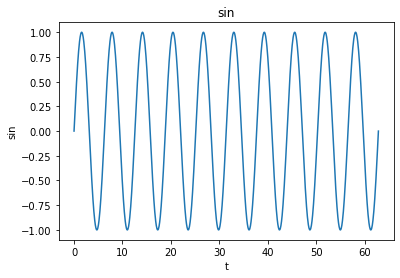

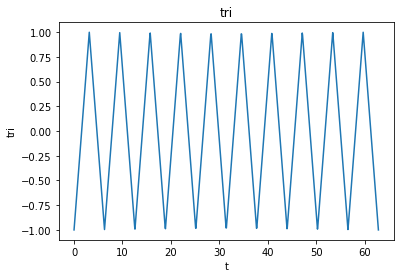

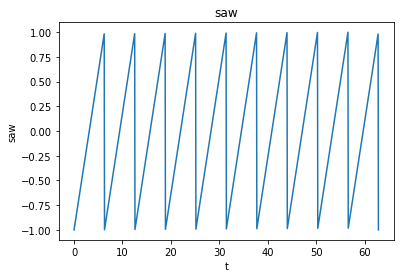

In [ ]:
samples = 1000
_, _ = ocilator_gen('sin', 10, 2*np.pi, 0, samples, True)
_, _ = ocilator_gen('tri', 10, 2*np.pi, 0, samples, True)
_, _ = ocilator_gen('saw', 10, 2*np.pi, 0, samples, True)

# 1D-Space

## Simple RNN

### sin

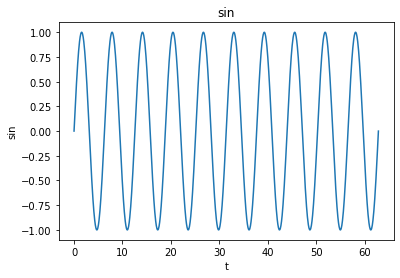

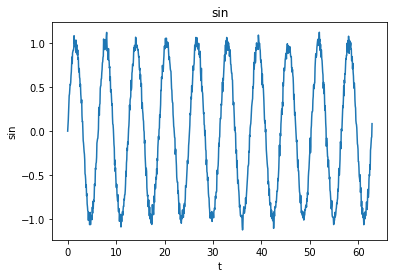

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0065 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0014 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0014 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step



test loss = 0.0014183830935508013


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0817
valid MSE: 0.0769
test MSE: 0.0848


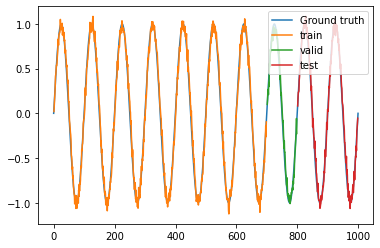

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 225.32192098165478


### tri

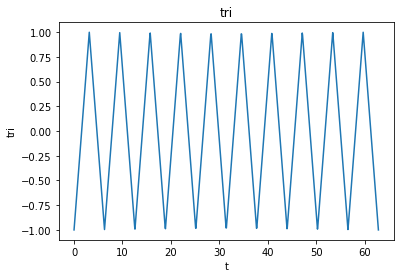

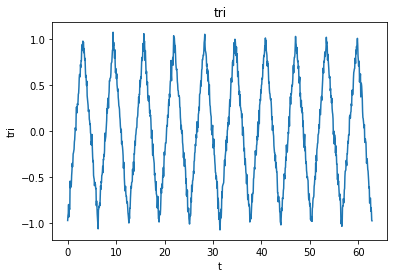

In [ ]:
# add noise
samples = 1000
functype = 'tri'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0954 - val_loss: 0.0130 - 2s/epoch - 3ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0049 - val_loss: 0.0019 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step



test loss = 0.0014501232653856277


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0849
valid MSE: 0.0867
test MSE: 0.0817


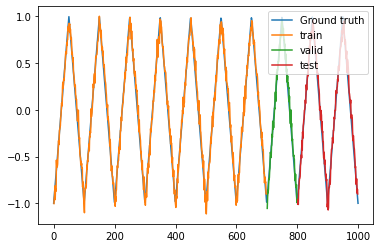

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 317.08057009240486


### saw

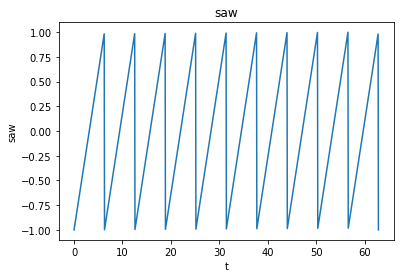

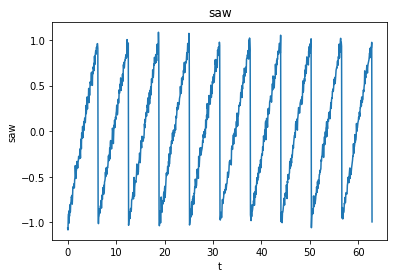

In [ ]:
# add noise
samples = 1000
functype = 'saw'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0472 - val_loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0082 - val_loss: 0.0019 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0076 - val_loss: 0.0022 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0076 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0079 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0078 - val_loss: 0.0012 - 1s/epoch - 2ms/step



test loss = 0.004541813861578703


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1861
valid MSE: 0.0751
test MSE: 0.1461


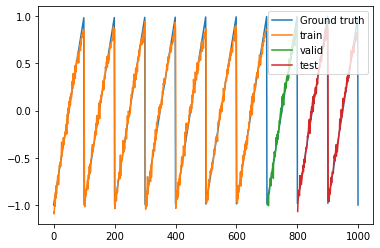

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 552.9355982644704


## LSTM

### sin

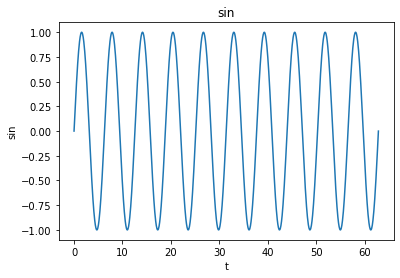

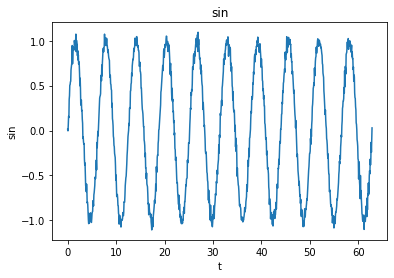

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0605 - val_loss: 0.0106 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 2s - loss: 0.0039 - val_loss: 0.0016 - 2s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 2s - loss: 0.0017 - val_loss: 0.0013 - 2s/epoch - 2ms/step



test loss = 0.0013966313563287258


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0875
valid MSE: 0.0809
test MSE: 0.0830


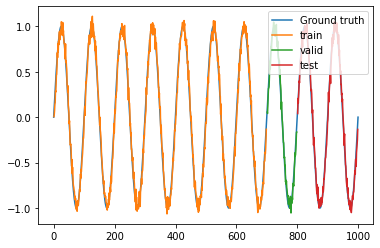

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 537.7191251313174


### tri

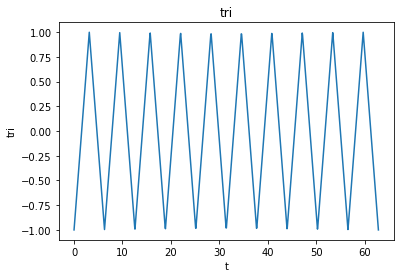

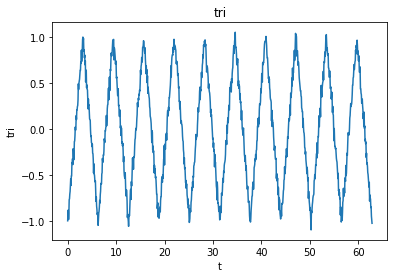

In [ ]:
# add noise
samples = 1000
functype = 'tri'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
689/689 - 4s - loss: 0.0308 - val_loss: 0.0060 - 4s/epoch - 6ms/step
Epoch 2/10
689/689 - 1s - loss: 0.0036 - val_loss: 0.0022 - 1s/epoch - 2ms/step
Epoch 3/10
689/689 - 1s - loss: 0.0015 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
689/689 - 1s - loss: 0.0013 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 5/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 6/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 7/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 8/10
689/689 - 1s - loss: 0.0011 - val_loss: 9.7820e-04 - 1s/epoch - 2ms/step
Epoch 9/10
689/689 - 1s - loss: 0.0011 - val_loss: 9.7809e-04 - 1s/epoch - 2ms/step
Epoch 10/10
689/689 - 1s - loss: 0.0011 - val_loss: 0.0011 - 1s/epoch - 2ms/step



test loss = 0.0011479281820356846


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0708
valid MSE: 0.0718
test MSE: 0.0727


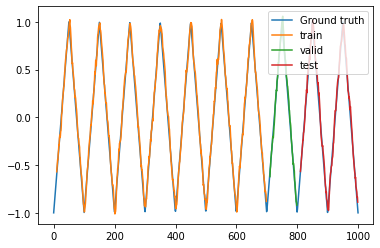

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 641.6999913172956


### saw

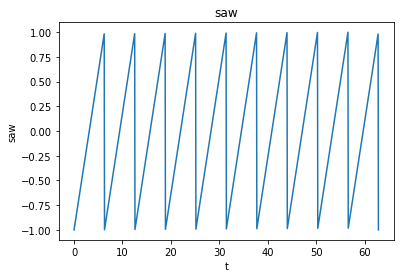

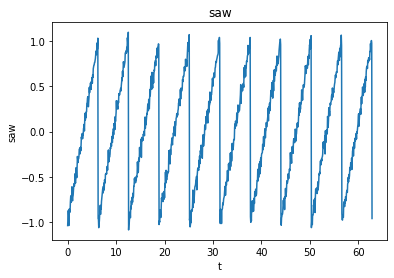

In [ ]:
# add noise
samples = 1000
functype = 'saw'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0664 - val_loss: 0.0175 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0155 - val_loss: 0.0041 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0095 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0087 - val_loss: 0.0047 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0023 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0087 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0086 - val_loss: 0.0011 - 1s/epoch - 2ms/step



test loss = 0.004613384138792753


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1988
valid MSE: 0.0705
test MSE: 0.1477


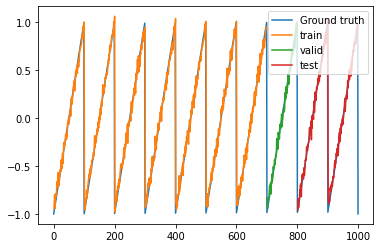

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 1932.3187060644009


## Effect of some hyperparameters on signal

### Variance 

mu =  0.05


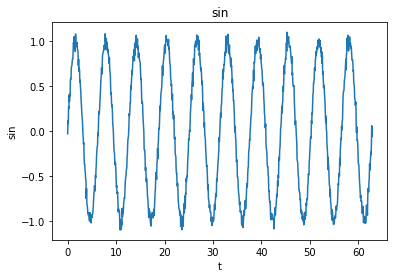

test loss = 0.000936469528824091 

train MSE: 0.0657
valid MSE: 0.0651
test MSE: 0.0674 



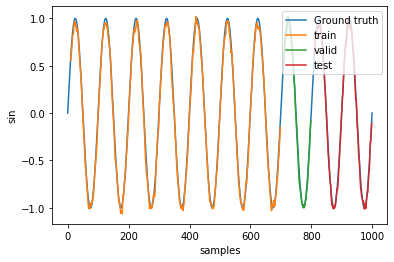

mu =  0.1


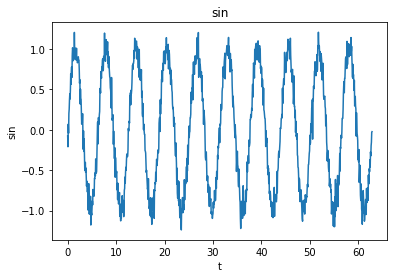

test loss = 0.0029282551258802414 

train MSE: 0.1183
valid MSE: 0.1087
test MSE: 0.1323 



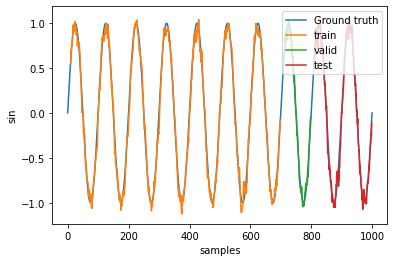

mu =  0.2


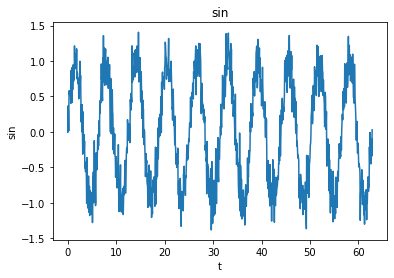

test loss = 0.006826096214354038 

train MSE: 0.2366
valid MSE: 0.2412
test MSE: 0.2304 



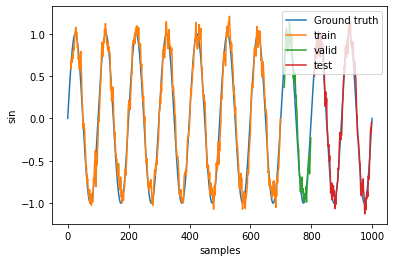

mu =  0.3


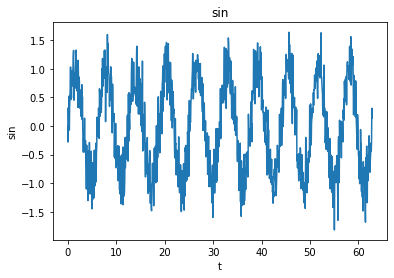

test loss = 0.010113395750522614 

train MSE: 0.3415
valid MSE: 0.3208
test MSE: 0.3469 



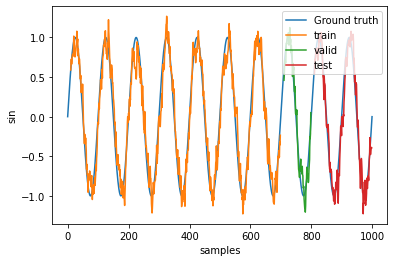

mu =  0.5


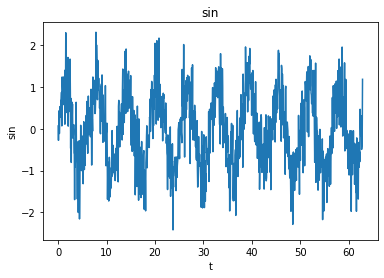

test loss = 0.015178567729890347 

train MSE: 0.5794
valid MSE: 0.5816
test MSE: 0.5831 



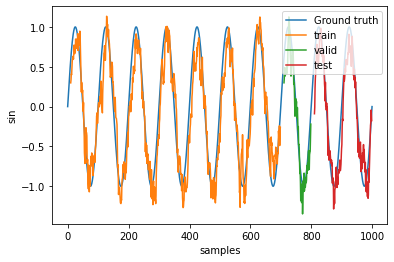

In [ ]:
samples = 1000
functype = 'sin'

for sigma in [0.05, 0.1, 0.2, 0.3, 0.5]:
  print('====================================================================')
  print('sigma = ', sigma)
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 10
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

### Learning rate

LR =  0.001


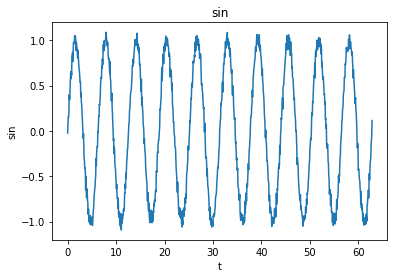

test loss = 0.0016590168233960867 

train MSE: 0.0860
valid MSE: 0.0849
test MSE: 0.0888 



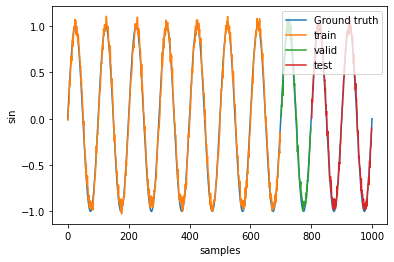

LR =  0.01


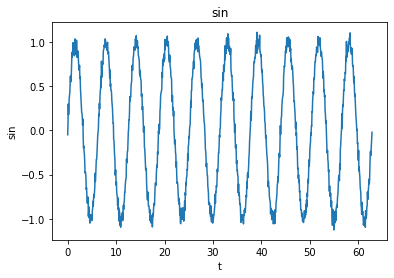

test loss = 0.002317448379471898 

train MSE: 0.1040
valid MSE: 0.0999
test MSE: 0.1075 



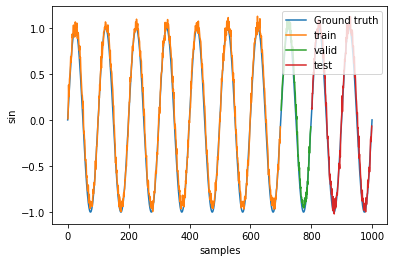

LR =  0.1


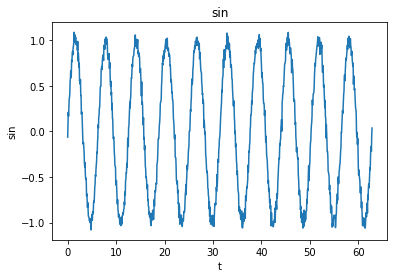

test loss = 0.0067498995922505856 

train MSE: 0.1766
valid MSE: 0.1805
test MSE: 0.1782 



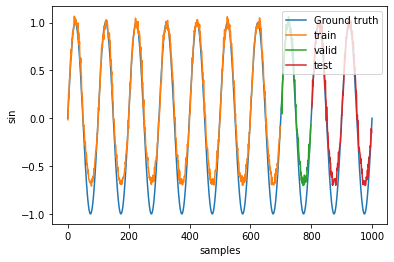

LR =  0.2


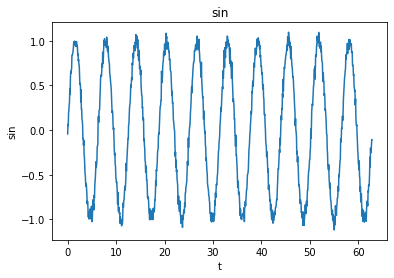

test loss = 0.020542632788419724 

train MSE: 0.3174
valid MSE: 0.3142
test MSE: 0.3176 



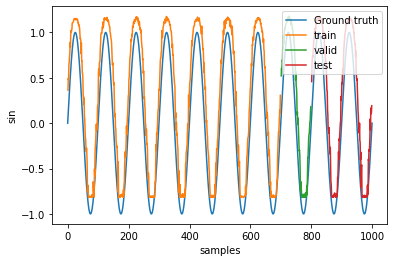

In [ ]:
for LR in [0.001, 0.01, 0.1, 0.2]:
  print('====================================================================')
  print('LR = ', LR)
  sigma = 0.05
  noise = np.random.normal(0,sigma,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=LR)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

### Batch size

batch size =  1


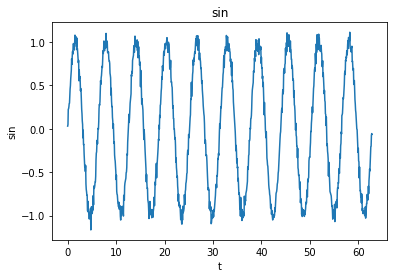

test loss = 0.0014782153302803636 

train MSE: 0.0863
valid MSE: 0.0942
test MSE: 0.0876 



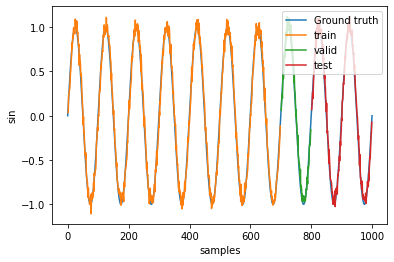

batch size =  10


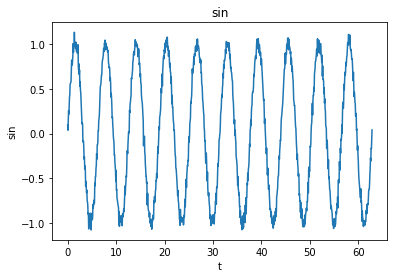

test loss = 0.002791646169498563 

train MSE: 0.1116
valid MSE: 0.1133
test MSE: 0.1165 



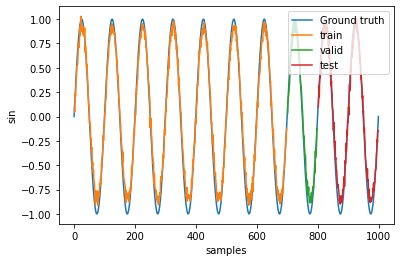

batch size =  30


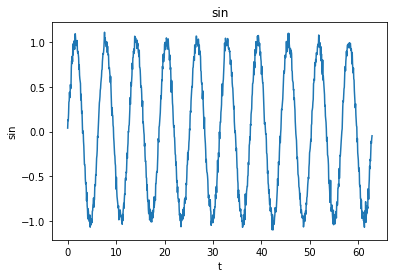

test loss = 0.039389245212078094 

train MSE: 0.4402
valid MSE: 0.4395
test MSE: 0.4387 



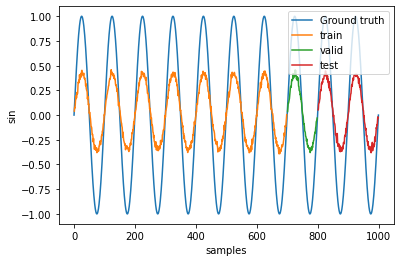

batch size =  50


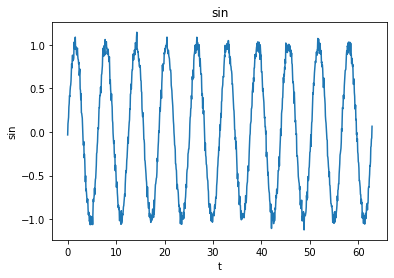

test loss = 0.059338320046663284 

train MSE: 0.5501
valid MSE: 0.5585
test MSE: 0.5519 



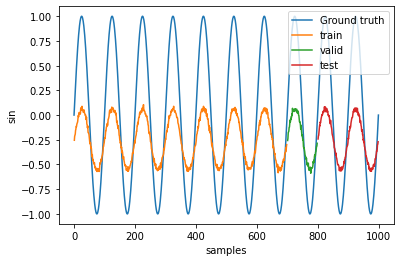

batch size =  100


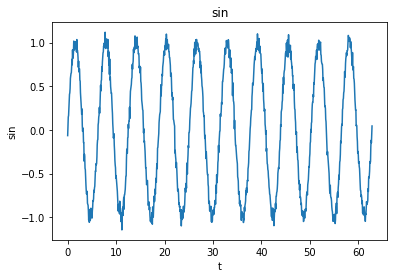

test loss = 0.15922638773918152 

train MSE: 0.9017
valid MSE: 0.9071
test MSE: 0.9042 



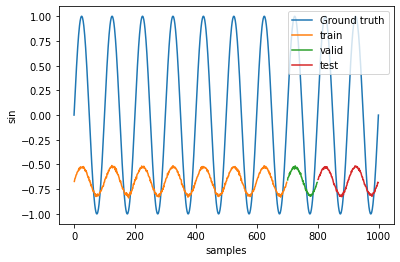

In [ ]:
for batch_size in [1, 10, 30, 50, 100]:
  print('====================================================================')
  print('batch size = ', batch_size)
  sigma = 0.05
  noise = np.random.normal(0,sigma,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=batch_size, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

### Number of epochs

epoch =  1


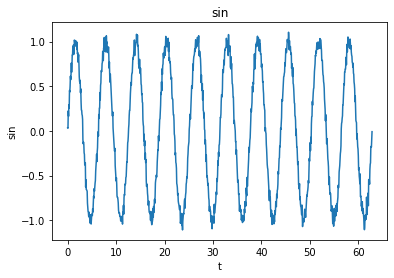

test loss = 0.014593610540032387 

train MSE: 0.2667
valid MSE: 0.2669
test MSE: 0.2674 



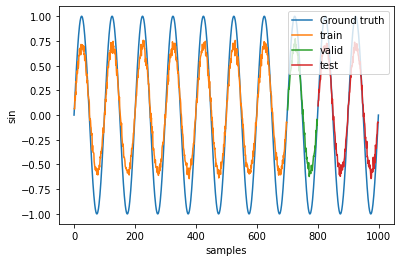

epoch =  5


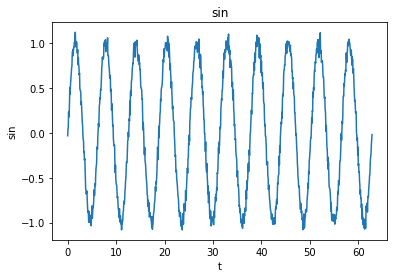

test loss = 0.0014935166109353304 

train MSE: 0.0876
valid MSE: 0.0772
test MSE: 0.0852 



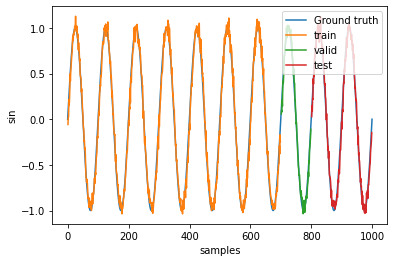

epoch =  10


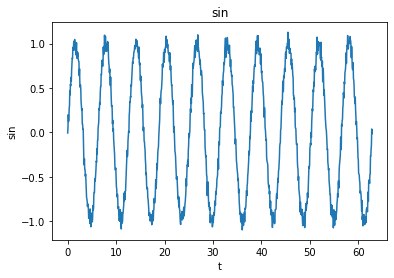

test loss = 0.001802915590815246 

train MSE: 0.0849
valid MSE: 0.0865
test MSE: 0.0945 



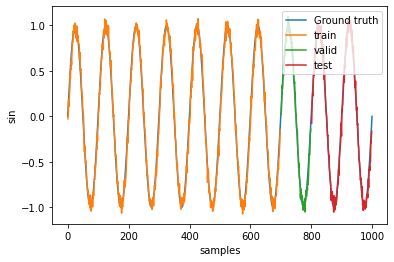

epoch =  20


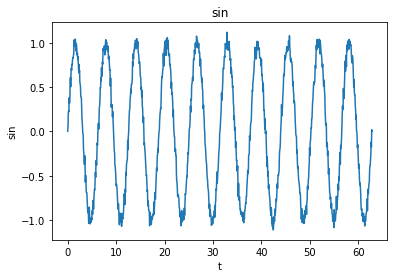

test loss = 0.0015026602195575833 

train MSE: 0.0822
valid MSE: 0.0786
test MSE: 0.0865 



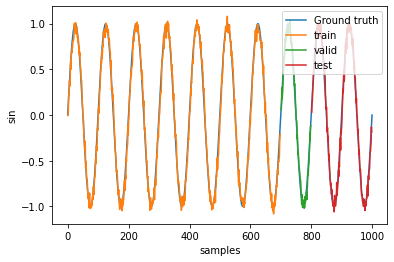

epoch =  30


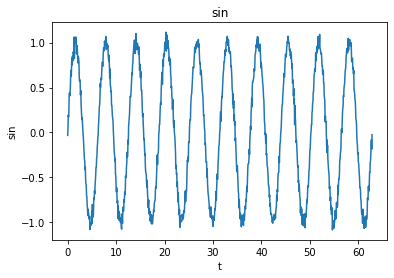

test loss = 0.0014618284767493606 

train MSE: 0.0859
valid MSE: 0.0910
test MSE: 0.0841 



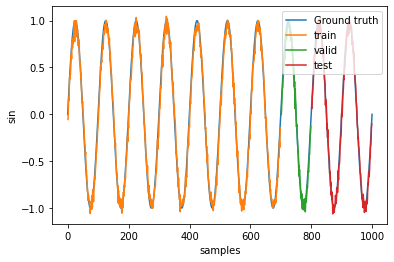

In [ ]:
for epoch in [1, 5, 10, 20, 30]:
  print('====================================================================')
  print('epoch = ', epoch)
  sigma = 0.05
  noise = np.random.normal(0,sigma,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=epoch, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Non-White noise

### Loopback = 1

Text(0.5, 1.0, 'noise')

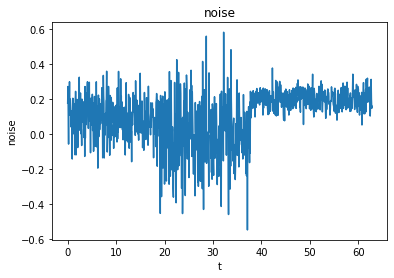

In [ ]:
# Create Non-White noise 
mu1 = 0.1
mu2 = 0
mu3 = 0.2

sigma1 = 0.1
sigma2 = 0.2
sigma3 = 0.05

arrays=[
    np.random.normal(mu1,sigma1,300),
    np.random.normal(mu2,sigma2,300),
    np.random.normal(mu3,sigma3,400)
]

# Create an array to return to
noise = np.array([])

for array in arrays:
    noise = np.concatenate([noise, array])

plt.plot(xaxis, noise)
plt.xlabel('t')
plt.ylabel('noise')
plt.title('noise')

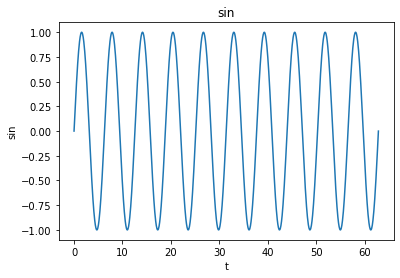

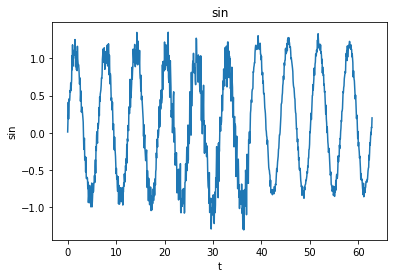

In [ ]:
# add noise
samples = 1000
functype = 'sin'
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0888 - val_loss: 0.0219 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0155 - val_loss: 0.0043 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0069 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0060 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0060 - val_loss: 8.8286e-04 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0060 - val_loss: 8.8335e-04 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0060 - val_loss: 8.8384e-04 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0060 - val_loss: 9.8082e-04 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0059 - val_loss: 9.7654e-04 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0061 - val_loss: 9.1269e-04 - 1s/epoch - 2ms/step



test loss = 0.0011284711072221398


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.2023
valid MSE: 0.0804
test MSE: 0.0895


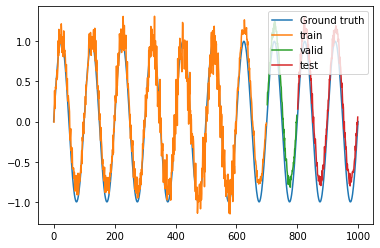

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 119.52882044799928


### Loopback = 10

Text(0.5, 1.0, 'noise')

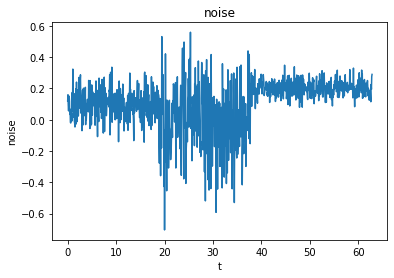

In [ ]:
# Create Non-White noise 
mu1 = 0.1
mu2 = 0
mu3 = 0.2

sigma1 = 0.1
sigma2 = 0.2
sigma3 = 0.05

arrays=[
    np.random.normal(mu1,sigma1,300),
    np.random.normal(mu2,sigma2,300),
    np.random.normal(mu3,sigma3,400)
]

# Create an array to return to
noise = np.array([])

for array in arrays:
    noise = np.concatenate([noise, array])

plt.plot(xaxis, noise)
plt.xlabel('t')
plt.ylabel('noise')
plt.title('noise')

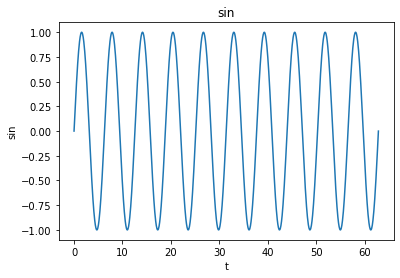

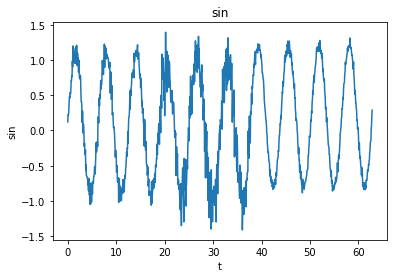

In [ ]:
# add noise
samples = 1000
functype = 'sin'
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
689/689 - 3s - loss: 0.0360 - val_loss: 0.0048 - 3s/epoch - 5ms/step
Epoch 2/10
689/689 - 1s - loss: 0.0058 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 3/10
689/689 - 1s - loss: 0.0048 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 4/10
689/689 - 1s - loss: 0.0046 - val_loss: 7.1134e-04 - 1s/epoch - 2ms/step
Epoch 5/10
689/689 - 1s - loss: 0.0045 - val_loss: 6.5986e-04 - 1s/epoch - 2ms/step
Epoch 6/10
689/689 - 1s - loss: 0.0045 - val_loss: 7.0206e-04 - 1s/epoch - 2ms/step
Epoch 7/10
689/689 - 1s - loss: 0.0045 - val_loss: 8.6790e-04 - 1s/epoch - 2ms/step
Epoch 8/10
689/689 - 1s - loss: 0.0043 - val_loss: 0.0024 - 1s/epoch - 2ms/step
Epoch 9/10
689/689 - 1s - loss: 0.0044 - val_loss: 7.2921e-04 - 1s/epoch - 2ms/step
Epoch 10/10
689/689 - 1s - loss: 0.0045 - val_loss: 9.4139e-04 - 1s/epoch - 2ms/step



test loss = 0.0008122880244627595


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1810
valid MSE: 0.0861
test MSE: 0.0800


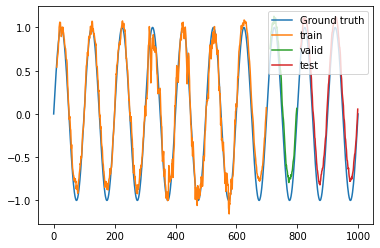

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 450.466434688481


# 2D-Space

## Circle


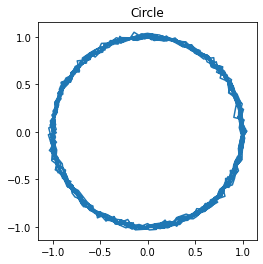

In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)

x = np.cos(t)
y = np.sin(t)

# Add noise
sigma = 0.02
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Circle')
plt.show()

In [ ]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
dataset.head()

x         y
0  1.010966 -0.016787
1  0.989091  0.105614
2  1.017422  0.123866
3  0.908425  0.151594
4  0.923838  0.235201

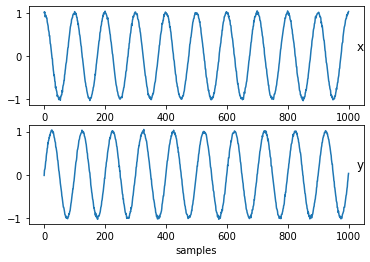

In [ ]:
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.984073         0.488528       0.973602       0.547326
2         0.973602         0.547326       0.987163       0.556093
3         0.987163         0.556093       0.934989       0.569413
4         0.934989         0.569413       0.942367       0.609575
5         0.942367         0.609575       0.949214       0.643509

In [ ]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (699, 1, 2)
valid x shape =  (99, 1, 2)
test x shape  =  (201, 1, 2)


### 1.SimpleRNN

Epoch 1/100
10/10 - 1s - loss: 0.3699 - val_loss: 0.2791 - 1s/epoch - 136ms/step
Epoch 2/100
10/10 - 0s - loss: 0.2317 - val_loss: 0.1733 - 43ms/epoch - 4ms/step
Epoch 3/100
10/10 - 0s - loss: 0.1456 - val_loss: 0.1130 - 47ms/epoch - 5ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0991 - val_loss: 0.0829 - 48ms/epoch - 5ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0757 - val_loss: 0.0668 - 62ms/epoch - 6ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0617 - val_loss: 0.0549 - 55ms/epoch - 5ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0504 - val_loss: 0.0447 - 46ms/epoch - 5ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0408 - val_loss: 0.0361 - 66ms/epoch - 7ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0330 - val_loss: 0.0291 - 49ms/epoch - 5ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0266 - val_loss: 0.0234 - 47ms/epoch - 5ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0214 - val_loss: 0.0188 - 46ms/epoch - 5ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0172 - val_loss: 0.0151 - 51ms/epoch - 5ms/step
Epoch 13/100
10/10 - 0s -

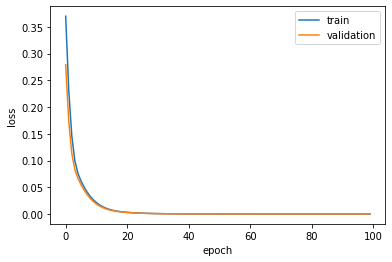




test loss = 0.0002029563911492005


In [ ]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.029
valid MSE: 0.029
test MSE: 0.030


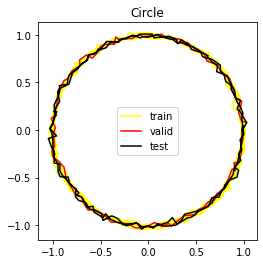


 SNR = 1221.2482610920397


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Circle')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

### 2.LSTM

Epoch 1/100
10/10 - 3s - loss: 0.3594 - val_loss: 0.3322 - 3s/epoch - 278ms/step
Epoch 2/100
10/10 - 0s - loss: 0.3170 - val_loss: 0.2920 - 59ms/epoch - 6ms/step
Epoch 3/100
10/10 - 0s - loss: 0.2776 - val_loss: 0.2540 - 54ms/epoch - 5ms/step
Epoch 4/100
10/10 - 0s - loss: 0.2402 - val_loss: 0.2177 - 57ms/epoch - 6ms/step
Epoch 5/100
10/10 - 0s - loss: 0.2043 - val_loss: 0.1828 - 72ms/epoch - 7ms/step
Epoch 6/100
10/10 - 0s - loss: 0.1701 - val_loss: 0.1502 - 68ms/epoch - 7ms/step
Epoch 7/100
10/10 - 0s - loss: 0.1387 - val_loss: 0.1210 - 52ms/epoch - 5ms/step
Epoch 8/100
10/10 - 0s - loss: 0.1112 - val_loss: 0.0965 - 57ms/epoch - 6ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0888 - val_loss: 0.0776 - 55ms/epoch - 5ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0721 - val_loss: 0.0643 - 53ms/epoch - 5ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0607 - val_loss: 0.0556 - 57ms/epoch - 6ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0534 - val_loss: 0.0500 - 55ms/epoch - 6ms/step
Epoch 13/100
10/10 - 0s -

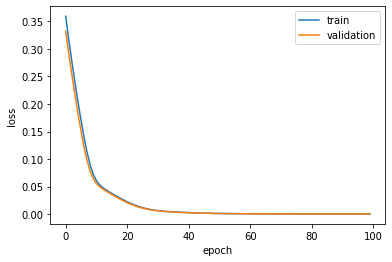




test loss = 0.000397110270569101


In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.041
valid MSE: 0.042
test MSE: 0.042


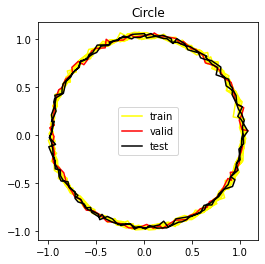


 SNR = 1215.4583458467407


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Circle')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

## Epidrochoid


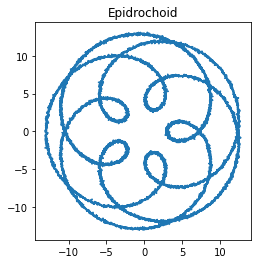

In [ ]:
samples = 10000
t = np.linspace(0, 10*2*np.pi, samples)
a = c = 5
b = 3

x = (a + b) * np.cos(t) - c * np.cos((a/b+1) * t)
y = (a + b) * np.sin(t) - c * np.sin((a/b+1) * t)

# Add noise
sigma = 0.1
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Epidrochoid')
plt.show()

In [ ]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
dataset.head()

x         y
0  2.946277 -0.014026
1  3.073211 -0.090570
2  2.997024 -0.089262
3  3.193676  0.075789
4  3.133983 -0.143804

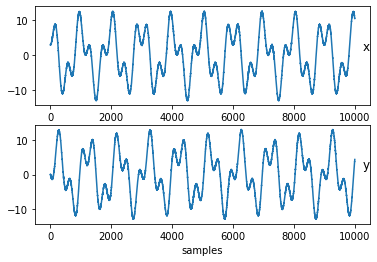

In [ ]:
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.620595         0.498126       0.625495       0.495197
2         0.625495         0.495197       0.622554       0.495248
3         0.622554         0.495248       0.630145       0.501561
4         0.630145         0.501561       0.627841       0.493161
5         0.627841         0.493161       0.624029       0.490911

In [ ]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (6999, 1, 2)
valid x shape =  (999, 1, 2)
test x shape  =  (2001, 1, 2)


### 1.SimpleRNN

Epoch 1/100
98/98 - 1s - loss: 0.0179 - val_loss: 0.0031 - 1s/epoch - 13ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0015 - val_loss: 1.5633e-04 - 219ms/epoch - 2ms/step
Epoch 3/100
98/98 - 0s - loss: 1.3095e-04 - val_loss: 5.8751e-05 - 237ms/epoch - 2ms/step
Epoch 4/100
98/98 - 0s - loss: 6.3696e-05 - val_loss: 5.0769e-05 - 231ms/epoch - 2ms/step
Epoch 5/100
98/98 - 0s - loss: 5.4576e-05 - val_loss: 5.1504e-05 - 242ms/epoch - 2ms/step
Epoch 6/100
98/98 - 0s - loss: 5.4147e-05 - val_loss: 5.3546e-05 - 256ms/epoch - 3ms/step
Epoch 7/100
98/98 - 0s - loss: 5.5014e-05 - val_loss: 5.6142e-05 - 235ms/epoch - 2ms/step
Epoch 8/100
98/98 - 0s - loss: 5.6193e-05 - val_loss: 5.8261e-05 - 248ms/epoch - 3ms/step
Epoch 9/100
98/98 - 0s - loss: 5.8161e-05 - val_loss: 5.8478e-05 - 217ms/epoch - 2ms/step
Epoch 10/100
98/98 - 0s - loss: 6.1840e-05 - val_loss: 5.5895e-05 - 215ms/epoch - 2ms/step
Epoch 11/100
98/98 - 0s - loss: 6.8242e-05 - val_loss: 5.1762e-05 - 254ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0

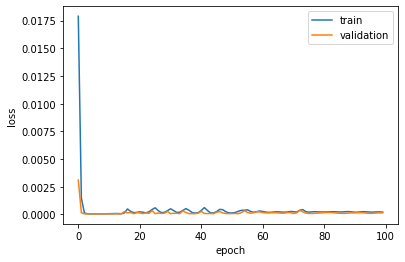




test loss = 0.00012845676974393427


In [ ]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.299
valid MSE: 0.312
test MSE: 0.294


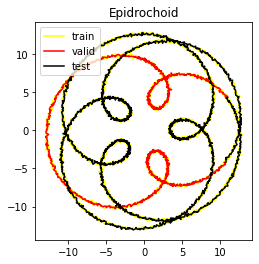


 SNR = 8562.850337324744


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Epidrochoid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

### 2.LSTM

Epoch 1/100
98/98 - 3s - loss: 0.1492 - val_loss: 0.0408 - 3s/epoch - 31ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0378 - val_loss: 0.0268 - 284ms/epoch - 3ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0283 - val_loss: 0.0201 - 300ms/epoch - 3ms/step
Epoch 4/100
98/98 - 0s - loss: 0.0201 - val_loss: 0.0133 - 304ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 0.0123 - val_loss: 0.0074 - 300ms/epoch - 3ms/step
Epoch 6/100
98/98 - 0s - loss: 0.0061 - val_loss: 0.0034 - 312ms/epoch - 3ms/step
Epoch 7/100
98/98 - 0s - loss: 0.0026 - val_loss: 0.0015 - 360ms/epoch - 4ms/step
Epoch 8/100
98/98 - 0s - loss: 0.0012 - val_loss: 7.8451e-04 - 324ms/epoch - 3ms/step
Epoch 9/100
98/98 - 0s - loss: 6.7564e-04 - val_loss: 4.6387e-04 - 311ms/epoch - 3ms/step
Epoch 10/100
98/98 - 0s - loss: 4.2579e-04 - val_loss: 2.9981e-04 - 315ms/epoch - 3ms/step
Epoch 11/100
98/98 - 0s - loss: 2.9529e-04 - val_loss: 2.1366e-04 - 301ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss: 2.2913e-04 - val_loss: 1.6978e-04 - 38

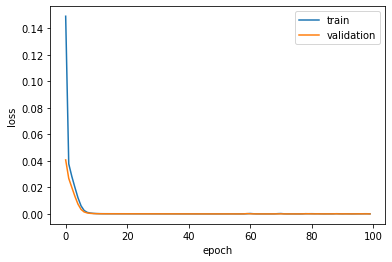




test loss = 4.5312615839065984e-05


In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.177
valid MSE: 0.179
test MSE: 0.175


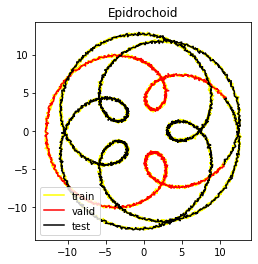


 SNR = 7647.530584916355


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Epidrochoid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

## Nephroid


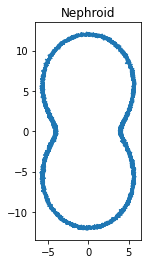

In [ ]:
samples = 10000
t = np.linspace(0, 10*2*np.pi, samples)
a = 2

x = a * (np.cos(3 * t) - 3 * np.cos(t))
y = a * (np.sin(3 * t) - c * np.sin(t))

# Add noise
sigma = 0.1
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Nephroid')
plt.show()

In [ ]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
dataset.head()

x         y
0 -4.031058 -0.024548
1 -4.025073 -0.139162
2 -3.926680 -0.160356
3 -4.143060  0.005780
4 -4.072722  0.122080

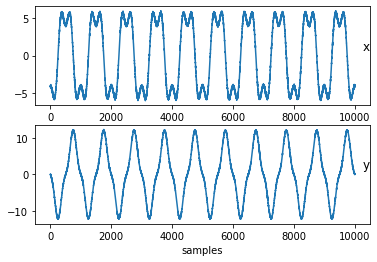

In [ ]:
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.163362         0.498213       0.163865       0.493536
2         0.163865         0.493536       0.172138       0.492671
3         0.172138         0.492671       0.153945       0.499451
4         0.153945         0.499451       0.159859       0.504197
5         0.159859         0.504197       0.146380       0.494983

In [ ]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (6999, 1, 2)
valid x shape =  (999, 1, 2)
test x shape  =  (2001, 1, 2)


### 1.SimpleRNN

Epoch 1/100
98/98 - 1s - loss: 0.0789 - val_loss: 0.0215 - 1s/epoch - 13ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0126 - val_loss: 0.0058 - 234ms/epoch - 2ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0039 - val_loss: 0.0020 - 220ms/epoch - 2ms/step
Epoch 4/100
98/98 - 0s - loss: 0.0014 - val_loss: 6.7766e-04 - 216ms/epoch - 2ms/step
Epoch 5/100
98/98 - 0s - loss: 4.6978e-04 - val_loss: 2.4053e-04 - 241ms/epoch - 2ms/step
Epoch 6/100
98/98 - 0s - loss: 1.8993e-04 - val_loss: 1.2979e-04 - 225ms/epoch - 2ms/step
Epoch 7/100
98/98 - 0s - loss: 1.2436e-04 - val_loss: 1.0871e-04 - 221ms/epoch - 2ms/step
Epoch 8/100
98/98 - 0s - loss: 1.1263e-04 - val_loss: 1.0571e-04 - 217ms/epoch - 2ms/step
Epoch 9/100
98/98 - 0s - loss: 1.1107e-04 - val_loss: 1.0538e-04 - 253ms/epoch - 3ms/step
Epoch 10/100
98/98 - 0s - loss: 1.1096e-04 - val_loss: 1.0530e-04 - 231ms/epoch - 2ms/step
Epoch 11/100
98/98 - 0s - loss: 1.1101e-04 - val_loss: 1.0522e-04 - 227ms/epoch - 2ms/step
Epoch 12/100
98/98 - 0s - loss: 1.1108

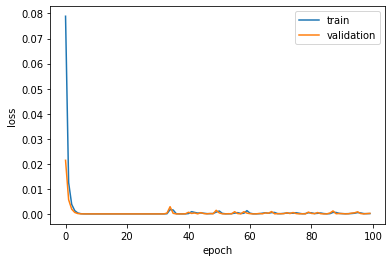




test loss = 0.0003182272776030004


In [ ]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.397
valid MSE: 0.396
test MSE: 0.396


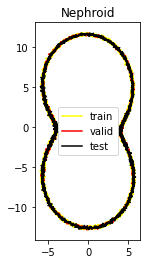


 SNR = 2184.289832075289


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Nephroid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

### 2.LSTM

Epoch 1/100
98/98 - 3s - loss: 0.2092 - val_loss: 0.0932 - 3s/epoch - 28ms/step
Epoch 2/100
98/98 - 0s - loss: 0.0693 - val_loss: 0.0567 - 313ms/epoch - 3ms/step
Epoch 3/100
98/98 - 0s - loss: 0.0499 - val_loss: 0.0403 - 334ms/epoch - 3ms/step
Epoch 4/100
98/98 - 0s - loss: 0.0326 - val_loss: 0.0229 - 320ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 0.0160 - val_loss: 0.0090 - 313ms/epoch - 3ms/step
Epoch 6/100
98/98 - 0s - loss: 0.0057 - val_loss: 0.0029 - 310ms/epoch - 3ms/step
Epoch 7/100
98/98 - 0s - loss: 0.0021 - val_loss: 0.0014 - 312ms/epoch - 3ms/step
Epoch 8/100
98/98 - 0s - loss: 0.0011 - val_loss: 8.2073e-04 - 292ms/epoch - 3ms/step
Epoch 9/100
98/98 - 0s - loss: 7.0609e-04 - val_loss: 5.5147e-04 - 292ms/epoch - 3ms/step
Epoch 10/100
98/98 - 0s - loss: 5.0276e-04 - val_loss: 4.2578e-04 - 316ms/epoch - 3ms/step
Epoch 11/100
98/98 - 0s - loss: 4.1091e-04 - val_loss: 3.7063e-04 - 284ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss: 3.7116e-04 - val_loss: 3.4582e-04 - 29

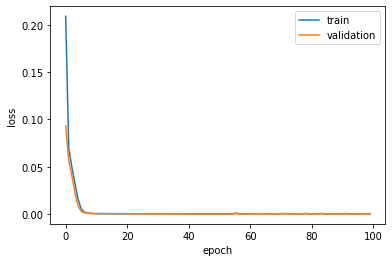




test loss = 0.00010788330109789968


In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.178
valid MSE: 0.177
test MSE: 0.176


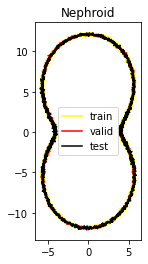


 SNR = 4030.3120344409162


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)
 
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Nephroid')
plt.legend()
plt.show()

print('\n SNR =', snr_f(x, noise, 2*np.pi))

## Effect of some hyperparameters on 2D-signals


### Variance

sigma =  0.02


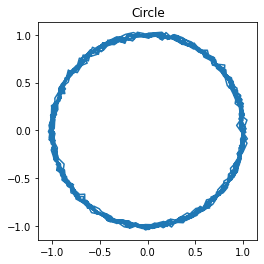

train loss =  0.00041981315007433295
valid loss =  0.0004160635871812701
test loss =  0.0004268022021278739

 train MSE: 0.042
valid MSE: 0.042
test MSE: 0.043


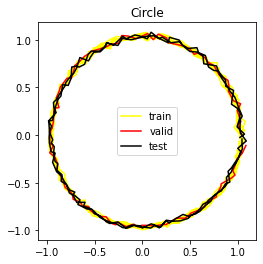


 SNR = 336.18700523065735
sigma =  0.05


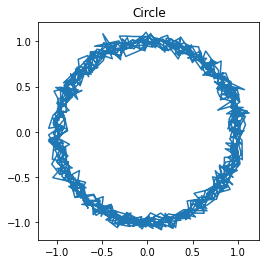

train loss =  0.0013915399322286248
valid loss =  0.001435949932783842
test loss =  0.0012994754360988736

 train MSE: 0.082
valid MSE: 0.084
test MSE: 0.080


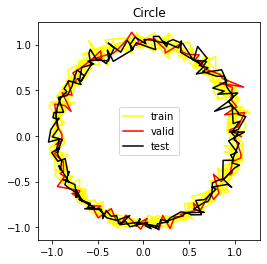


 SNR = 147.38276569295672
sigma =  0.1


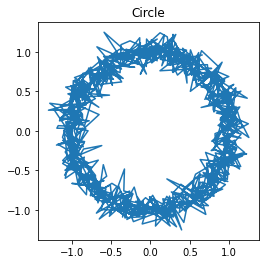

train loss =  0.0039439089596271515
valid loss =  0.0036983415484428406
test loss =  0.004018520470708609

 train MSE: 0.159
valid MSE: 0.154
test MSE: 0.160


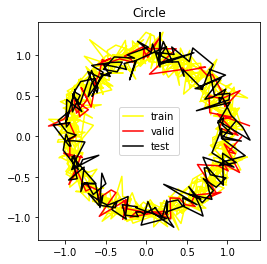


 SNR = 50.85499371431465
sigma =  0.2


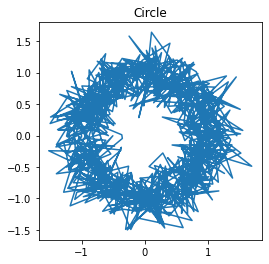

train loss =  0.010030004195868969
valid loss =  0.010079510509967804
test loss =  0.008924691937863827

 train MSE: 0.319
valid MSE: 0.320
test MSE: 0.301


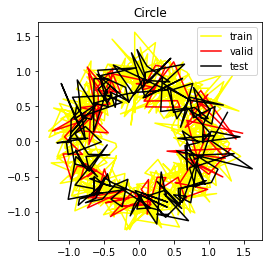


 SNR = 84.60757835318721
sigma =  0.3


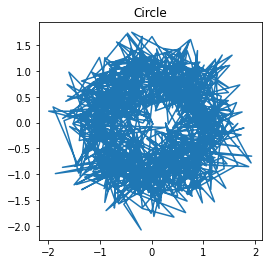

train loss =  0.017839815467596054
valid loss =  0.015008066780865192
test loss =  0.01831064186990261

 train MSE: 0.516
valid MSE: 0.474
test MSE: 0.524


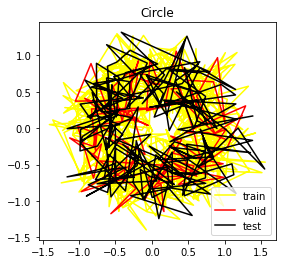


 SNR = 42.14983443474048
sigma =  0.5


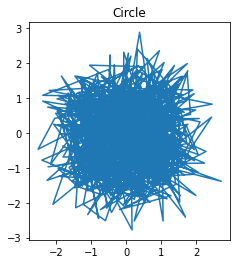

train loss =  0.021307187154889107
valid loss =  0.018519770354032516
test loss =  0.02219095081090927

 train MSE: 0.793
valid MSE: 0.740
test MSE: 0.809


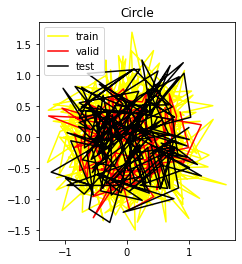


 SNR = 24.310431700708456


In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)
x = np.cos(t)
y = np.sin(t)
for sigma in [0.02, 0.05, 0.1, 0.2, 0.3, 0.5]:
  print('====================================================================')
  print('sigma = ', sigma)
  # Add noise
  noise = np.random.normal(0,sigma,samples)
  x = x + noise
  noise = np.random.normal(0,sigma,samples)
  y = y + noise
  figure, axes = plt.subplots(1)
  plt.plot(x, y)
  axes.set_aspect(1)
  plt.title('Circle')
  plt.show()
  # create dataframe
  data = np.array([x, y])
  dataset = pd.DataFrame({'x': x, 'y': y})
  values = dataset.values
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # split into train and test sets
  values = reframed.values
  le = int(len(reframed.columns)/2)
  train_size = int(reframed.values.shape[0] * 0.7)
  valid_size = int(reframed.values.shape[0] * 0.1)
  test_size = reframed.values.shape[0] - train_size - valid_size
  train = values[0:train_size, :]
  valid = values[train_size:train_size+valid_size,:]
  test = values[train_size+valid_size:, :]
  # split into input and outputs
  train_x, train_y = train[:, :le], train[:, le:]
  valid_x, valid_y = valid[:, :le], valid[:, le:]
  test_x, test_y = test[:, :le], test[:, le:]
  # reshape input to be 3D [samples, timesteps, features]
  train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
  valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(le))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=0, shuffle=False)
  score = model.evaluate(test_x, test_y, verbose=0)
  print('train loss = ', history.history['loss'][-1])
  print('valid loss = ', history.history['val_loss'][-1])
  print('test loss = ', score)
  # make predictions
  trainPredict = model.predict(train_x)
  validPredict = model.predict(valid_x)
  testPredict = model.predict(test_x)
  train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
  valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
  test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
  inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
  inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
  inv_validPredict = scaler.inverse_transform(inv_validPredict)
  inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
  inv_testPredict = scaler.inverse_transform(inv_testPredict)
  # invert scaling for actual
  inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
  inv_train = scaler.inverse_transform(inv_train)
  inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
  inv_valid = scaler.inverse_transform(inv_valid)
  inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
  inv_test = scaler.inverse_transform(inv_test)
  # calculate MSE
  mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
  print('\n train MSE: %.3f' % mse1)
  mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
  print('valid MSE: %.3f' % mse2)
  mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
  print('test MSE: %.3f' % mse3)
  # plot baseline and predictions
  figure, axes = plt.subplots(1)
  plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
  plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
  plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
  axes.set_aspect(1)
  plt.title('Circle')
  plt.legend()
  plt.show()
  print('\n SNR =', snr_f(inv_testPredict[:,0], noise[samples-test_size:], 2*np.pi))

### Learning rate

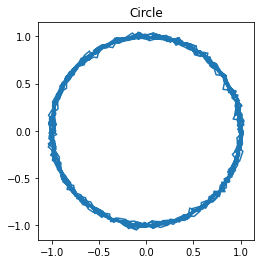

LR =  0.001
train loss =  0.00043181178625673056
valid loss =  0.0003944617637898773
test loss =  0.00042434039642103016

 train MSE: 0.043
valid MSE: 0.041
test MSE: 0.043


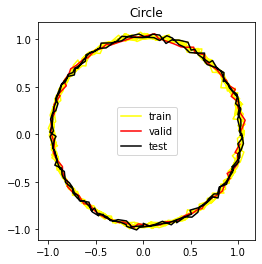


 SNR = 2055.1663641502773
LR =  0.01
train loss =  0.00018388676107861102
valid loss =  0.00014895739150233567
test loss =  0.00018085418560076505

 train MSE: 0.028
valid MSE: 0.025
test MSE: 0.028


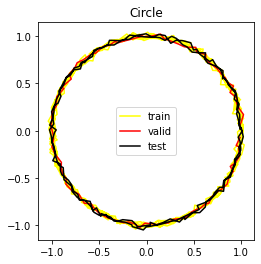


 SNR = 2061.3052643044557
LR =  0.1
train loss =  0.0023935441859066486
valid loss =  0.004454055335372686
test loss =  0.004477954003959894

 train MSE: 0.139
valid MSE: 0.139
test MSE: 0.139


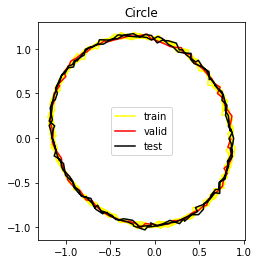


 SNR = 2094.724281030093
LR =  0.2
train loss =  0.00021376257063820958
valid loss =  0.00017295251018367708
test loss =  0.00020644777396228164

 train MSE: 0.030
valid MSE: 0.027
test MSE: 0.030


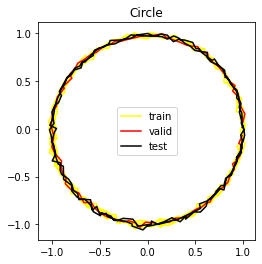


 SNR = 2063.8352845352056


In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)
x = np.cos(t)
y = np.sin(t)
# Add noise
sigma = 0.02
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise
figure, axes = plt.subplots(1)
plt.plot(x, y)
axes.set_aspect(1)
plt.title('Circle')
plt.show()
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
for LR in [0.001, 0.01, 0.1, 0.2]:
  print('====================================================================')
  print('LR = ', LR)
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(le))
  opt = tf.keras.optimizers.Adam(learning_rate=LR)
  model.compile(loss='mse', optimizer=opt)
  # fit network
  history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=0, shuffle=False)
  score = model.evaluate(test_x, test_y, verbose=0)
  print('train loss = ', history.history['loss'][-1])
  print('valid loss = ', history.history['val_loss'][-1])
  print('test loss = ', score)
  # make predictions
  trainPredict = model.predict(train_x)
  validPredict = model.predict(valid_x)
  testPredict = model.predict(test_x)
  train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
  valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
  test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
  inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
  inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
  inv_validPredict = scaler.inverse_transform(inv_validPredict)
  inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
  inv_testPredict = scaler.inverse_transform(inv_testPredict)
  # invert scaling for actual
  inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
  inv_train = scaler.inverse_transform(inv_train)
  inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
  inv_valid = scaler.inverse_transform(inv_valid)
  inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
  inv_test = scaler.inverse_transform(inv_test)
  # calculate MSE
  mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
  print('\n train MSE: %.3f' % mse1)
  mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
  print('valid MSE: %.3f' % mse2)
  mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
  print('test MSE: %.3f' % mse3)
  # plot baseline and predictions
  figure, axes = plt.subplots(1)
  plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
  plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
  plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
  axes.set_aspect(1)
  plt.title('Circle')
  plt.legend()
  plt.show()
  print('\n SNR =', snr_f(inv_testPredict[:,0], noise[samples-test_size:], 2*np.pi))

### Batch size

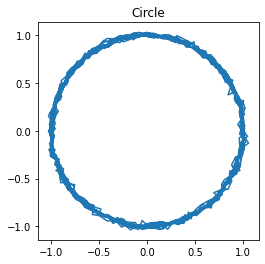

batch size =  1
train loss =  0.0007244457956403494
valid loss =  0.0033059120178222656
test loss =  0.003229402471333742

 train MSE: 0.120
valid MSE: 0.120
test MSE: 0.119


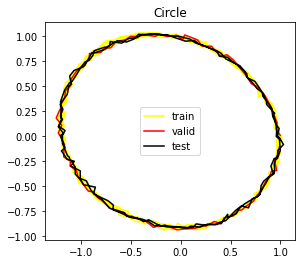


 SNR = 271.97041559884775
batch size =  10
train loss =  0.0002003125409828499
valid loss =  0.00017874706827569753
test loss =  0.00018209550762549043

 train MSE: 0.028
valid MSE: 0.028
test MSE: 0.028


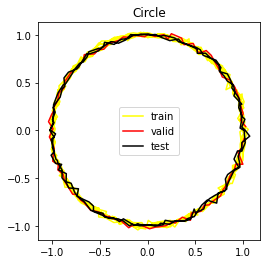


 SNR = 233.0156378197244
batch size =  30
train loss =  0.0003005453327205032
valid loss =  0.00030065816827118397
test loss =  0.0002927582827396691

 train MSE: 0.036
valid MSE: 0.036
test MSE: 0.036


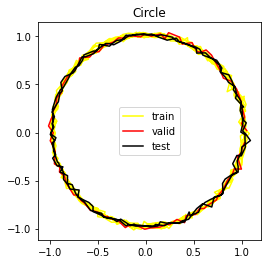


 SNR = 233.5164408343389
batch size =  50
train loss =  0.0003790721239056438
valid loss =  0.00038385335938073695
test loss =  0.0003707287833094597

 train MSE: 0.040
valid MSE: 0.041
test MSE: 0.040


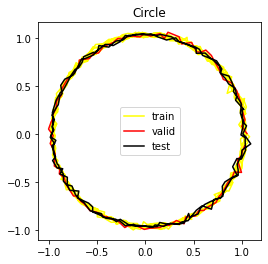


 SNR = 233.55695997719764
batch size =  100
train loss =  0.00042251174454577267
valid loss =  0.00042971648508682847
test loss =  0.00041377710294909775

 train MSE: 0.043
valid MSE: 0.043
test MSE: 0.042


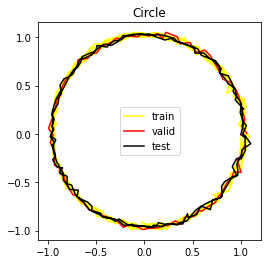


 SNR = 233.47087687387977


In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)
x = np.cos(t)
y = np.sin(t)
# Add noise
sigma = 0.02
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise
figure, axes = plt.subplots(1)
plt.plot(x, y)
axes.set_aspect(1)
plt.title('Circle')
plt.show()
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
for batch_size in [1, 10, 30, 50, 100]:
  print('====================================================================')
  print('batch size = ', batch_size)
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(le))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  history = model.fit(train_x, train_y, epochs=100, batch_size=batch_size, validation_data=(valid_x, valid_y), verbose=0, shuffle=False)
  score = model.evaluate(test_x, test_y, verbose=0)
  print('train loss = ', history.history['loss'][-1])
  print('valid loss = ', history.history['val_loss'][-1])
  print('test loss = ', score)
  # make predictions
  trainPredict = model.predict(train_x)
  validPredict = model.predict(valid_x)
  testPredict = model.predict(test_x)
  train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
  valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
  test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
  inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
  inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
  inv_validPredict = scaler.inverse_transform(inv_validPredict)
  inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
  inv_testPredict = scaler.inverse_transform(inv_testPredict)
  # invert scaling for actual
  inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
  inv_train = scaler.inverse_transform(inv_train)
  inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
  inv_valid = scaler.inverse_transform(inv_valid)
  inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
  inv_test = scaler.inverse_transform(inv_test)
  # calculate MSE
  mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
  print('\n train MSE: %.3f' % mse1)
  mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
  print('valid MSE: %.3f' % mse2)
  mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
  print('test MSE: %.3f' % mse3)
  # plot baseline and predictions
  figure, axes = plt.subplots(1)
  plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
  plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
  plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
  axes.set_aspect(1)
  plt.title('Circle')
  plt.legend()
  plt.show()
  print('\n SNR =', snr_f(inv_testPredict[:,0], noise[samples-test_size:], 2*np.pi))

### Number of epochs

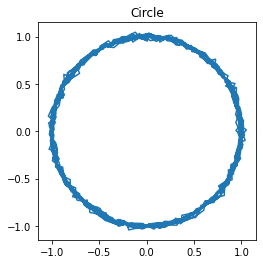

epoch =  5
train loss =  0.17403452098369598
valid loss =  0.15271960198879242
test loss =  0.1533232480287552

 train MSE: 0.818
valid MSE: 0.816
test MSE: 0.818


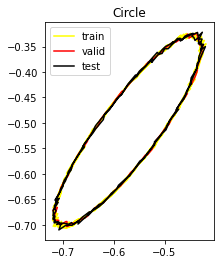


 SNR = 229.06924734990952
epoch =  30
train loss =  0.00842820294201374
valid loss =  0.007614501751959324
test loss =  0.007635833229869604

 train MSE: 0.183
valid MSE: 0.182
test MSE: 0.182


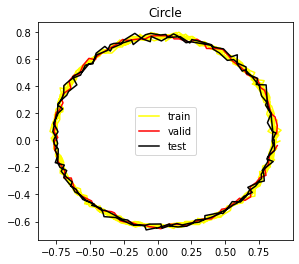


 SNR = 419.81602470214466
epoch =  50
train loss =  0.001316420966759324
valid loss =  0.001201370730996132
test loss =  0.00126192148309201

 train MSE: 0.074
valid MSE: 0.072
test MSE: 0.074


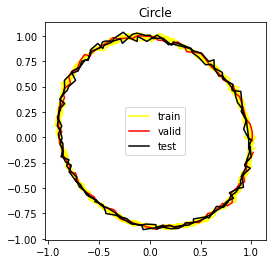


 SNR = 489.7906566766094
epoch =  70
train loss =  0.0004356808785814792
valid loss =  0.0003926757490262389
test loss =  0.0004440360062289983

 train MSE: 0.044
valid MSE: 0.041
test MSE: 0.044


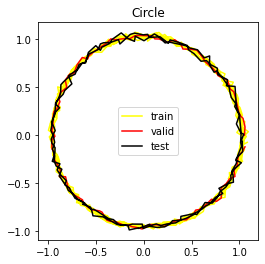


 SNR = 514.3014045401692
epoch =  100
train loss =  0.0003904067270923406
valid loss =  0.00034998124465346336
test loss =  0.0003989592660218477

 train MSE: 0.041
valid MSE: 0.039
test MSE: 0.042


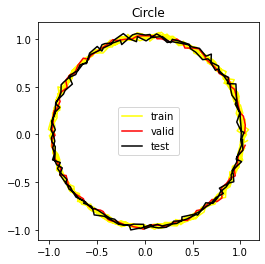


 SNR = 512.9936130658931
epoch =  120
train loss =  0.00038889190182089806
valid loss =  0.00034802910522557795
test loss =  0.0003972236008848995

 train MSE: 0.041
valid MSE: 0.039
test MSE: 0.042


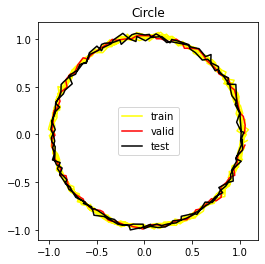


 SNR = 514.6598357372663


In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)
x = np.cos(t)
y = np.sin(t)
# Add noise
sigma = 0.02
noise = np.random.normal(0,sigma,samples)
x = x + noise
noise = np.random.normal(0,sigma,samples)
y = y + noise
figure, axes = plt.subplots(1)
plt.plot(x, y)
axes.set_aspect(1)
plt.title('Circle')
plt.show()
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
for epoch in [5, 30, 50, 70, 100, 120]:
  print('====================================================================')
  print('epoch = ', epoch)
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(le))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  history = model.fit(train_x, train_y, epochs=epoch, batch_size=72, validation_data=(valid_x, valid_y), verbose=0, shuffle=False)
  score = model.evaluate(test_x, test_y, verbose=0)
  print('train loss = ', history.history['loss'][-1])
  print('valid loss = ', history.history['val_loss'][-1])
  print('test loss = ', score)
  # make predictions
  trainPredict = model.predict(train_x)
  validPredict = model.predict(valid_x)
  testPredict = model.predict(test_x)
  train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
  valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
  test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
  # invert scaling for forecast
  inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
  inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
  inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
  inv_validPredict = scaler.inverse_transform(inv_validPredict)
  inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
  inv_testPredict = scaler.inverse_transform(inv_testPredict)
  # invert scaling for actual
  inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
  inv_train = scaler.inverse_transform(inv_train)
  inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
  inv_valid = scaler.inverse_transform(inv_valid)
  inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
  inv_test = scaler.inverse_transform(inv_test)
  # calculate MSE
  mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
  print('\n train MSE: %.3f' % mse1)
  mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
  print('valid MSE: %.3f' % mse2)
  mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
  print('test MSE: %.3f' % mse3)
  # plot baseline and predictions
  figure, axes = plt.subplots(1)
  plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
  plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
  plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
  axes.set_aspect(1)
  plt.title('Circle')
  plt.legend()
  plt.show()
  print('\n SNR =', snr_f(inv_testPredict[:,0], noise[samples-test_size:], 2*np.pi))

## Non-White noise

Text(0.5, 1.0, 'samples')

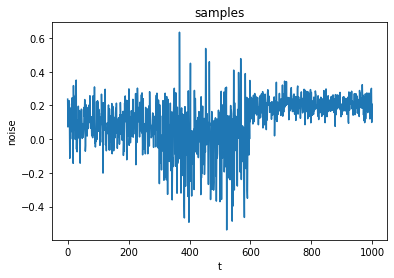

In [ ]:
# Create Non-White noise 
def create_noise():
  mu1 = 0.1
  mu2 = 0
  mu3 = 0.2

  sigma1 = 0.1
  sigma2 = 0.2
  sigma3 = 0.05

  arrays=[
      np.random.normal(mu1,sigma1,300),
      np.random.normal(mu2,sigma2,300),
      np.random.normal(mu3,sigma3,400)
  ]

  # Create an array to return to
  noise = np.array([])

  for array in arrays:
      noise = np.concatenate([noise, array])
  return noise


plt.plot(create_noise())
plt.xlabel('t')
plt.ylabel('noise')
plt.title('samples')

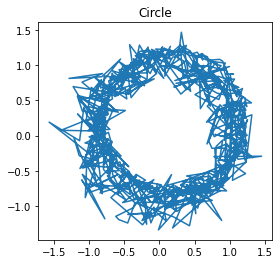

In [ ]:
samples = 1000
t = np.linspace(0, 10*2*np.pi, samples)

x = np.cos(t)
y = np.sin(t)

# Add noise
x = x + create_noise()
y = y + create_noise()

figure, axes = plt.subplots(1)
 
plt.plot(x, y)
axes.set_aspect(1)
 
plt.title('Circle')
plt.show()

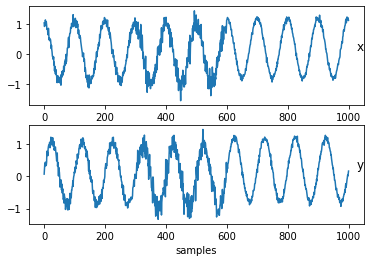

variable_1(t-1)  variable_2(t-1)  variable_1(t)  variable_2(t)
1         0.865965         0.502738       0.826083       0.552814
2         0.826083         0.552814       0.845157       0.615289
3         0.845157         0.615289       0.858196       0.619715
4         0.858196         0.619715       0.899242       0.636128
5         0.899242         0.636128       0.860946       0.594701

In [ ]:
# create dataframe
data = np.array([x, y])
dataset = pd.DataFrame({'x': x, 'y': y})
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	plt.xlabel('samples')
	i += 1
plt.show()
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

In [ ]:
# split into train and test sets
values = reframed.values
le = int(len(reframed.columns)/2)
train_size = int(reframed.values.shape[0] * 0.7)
valid_size = int(reframed.values.shape[0] * 0.1)
test_size = reframed.values.shape[0] - train_size - valid_size
train = values[0:train_size, :]
valid = values[train_size:train_size+valid_size,:]
test = values[train_size+valid_size:, :]
# split into input and outputs
train_x, train_y = train[:, :le], train[:, le:]
valid_x, valid_y = valid[:, :le], valid[:, le:]
test_x, test_y = test[:, :le], test[:, le:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train x shape = ', train_x.shape)
print('valid x shape = ', valid_x.shape)
print('test x shape  = ', test_x.shape)

train x shape =  (699, 1, 2)
valid x shape =  (99, 1, 2)
test x shape  =  (201, 1, 2)


Epoch 1/100
10/10 - 3s - loss: 0.2885 - val_loss: 0.3042 - 3s/epoch - 270ms/step
Epoch 2/100
10/10 - 0s - loss: 0.2495 - val_loss: 0.2613 - 60ms/epoch - 6ms/step
Epoch 3/100
10/10 - 0s - loss: 0.2120 - val_loss: 0.2193 - 57ms/epoch - 6ms/step
Epoch 4/100
10/10 - 0s - loss: 0.1753 - val_loss: 0.1778 - 62ms/epoch - 6ms/step
Epoch 5/100
10/10 - 0s - loss: 0.1398 - val_loss: 0.1383 - 54ms/epoch - 5ms/step
Epoch 6/100
10/10 - 0s - loss: 0.1071 - val_loss: 0.1028 - 56ms/epoch - 6ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0793 - val_loss: 0.0739 - 60ms/epoch - 6ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0582 - val_loss: 0.0531 - 59ms/epoch - 6ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0445 - val_loss: 0.0405 - 70ms/epoch - 7ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0372 - val_loss: 0.0339 - 57ms/epoch - 6ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0338 - val_loss: 0.0307 - 57ms/epoch - 6ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0320 - val_loss: 0.0289 - 64ms/epoch - 6ms/step
Epoch 13/100
10/10 - 0s -

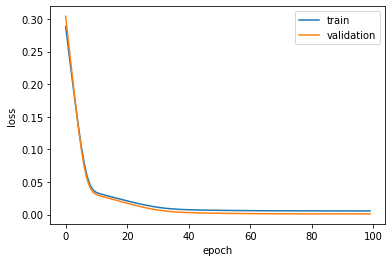




test loss = 0.0007082338561303914


In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(le))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print('\n\n')
score = model.evaluate(test_x, test_y, verbose=0)
print('test loss =', score)
noise = np.random.normal(0,sigma,samples)

In [ ]:
# make predictions
trainPredict = model.predict(train_x)
validPredict = model.predict(valid_x)
testPredict = model.predict(test_x)
train_xr = train_x.reshape((train_x.shape[0], train_x.shape[2]))
valid_xr = valid_x.reshape((valid_x.shape[0], valid_x.shape[2]))
test_xr = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_trainPredict = np.concatenate((trainPredict, train_xr[:, le:]), axis=1)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
inv_validPredict = np.concatenate((validPredict, valid_xr[:, le:]), axis=1)
inv_validPredict = scaler.inverse_transform(inv_validPredict)
inv_testPredict = np.concatenate((testPredict, test_xr[:, le:]), axis=1)
inv_testPredict = scaler.inverse_transform(inv_testPredict)
# invert scaling for actual
inv_train = np.concatenate((train_y, train_xr[:, le:]), axis=1)
inv_train = scaler.inverse_transform(inv_train)
inv_valid = np.concatenate((valid_y, valid_xr[:, le:]), axis=1)
inv_valid = scaler.inverse_transform(inv_valid)
inv_test = np.concatenate((test_y, test_xr[:, le:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
# calculate MSE
mse1 = math.sqrt(mean_squared_error(inv_train, inv_trainPredict))
print('train MSE: %.3f' % mse1)
mse2 = math.sqrt(mean_squared_error(inv_valid, inv_validPredict))
print('valid MSE: %.3f' % mse2)
mse3 = math.sqrt(mean_squared_error(inv_test, inv_testPredict))
print('test MSE: %.3f' % mse3)

train MSE: 0.215
valid MSE: 0.087
test MSE: 0.077


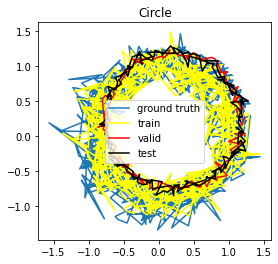


 SNR = 353.72893407420366


In [ ]:
# plot baseline and predictions
figure, axes = plt.subplots(1)

plt.plot(x, y, label='ground truth')
plt.plot(inv_trainPredict[:,0], inv_trainPredict[:,1], label='train', color='yellow')
plt.plot(inv_validPredict[:,0], inv_validPredict[:,1], label='valid', color='red')
plt.plot(inv_testPredict[:,0], inv_testPredict[:,1], label='test', color='black')
axes.set_aspect(1)
 
plt.title('Circle')
plt.legend()
plt.show()

print('\n SNR =', snr_f(inv_testPredict[:,0], noise[samples-test_size:], 2*np.pi))

# Voice

In [ ]:
! wget -nc 'https://www.bensound.com/bensound-music/bensound-creativeminds.mp3'
! cp 'bensound-creativeminds.mp3' 'sound.mp3'
! pip install pydub

--2022-01-13 13:19:10--  https://www.bensound.com/bensound-music/bensound-creativeminds.mp3
Resolving www.bensound.com (www.bensound.com)... 147.135.79.36
Connecting to www.bensound.com (www.bensound.com)|147.135.79.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2945044 (2.8M) [application/octet-stream]
Saving to: ‘bensound-creativeminds.mp3’

bensound-creativemi 100%[===================>]   2.81M  --.-KB/s    in 0.09s   

2022-01-13 13:19:10 (30.3 MB/s) - ‘bensound-creativeminds.mp3’ saved [2945044/2945044]



In [ ]:
from os import path
from pydub import AudioSegment
import librosa
import librosa.display as display
from IPython.display import Audio
import soundfile as sf

# files                                                                         
src = "sound.mp3"
dst = "sound.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='sound.wav'>

In [ ]:
SR = 3200

seq, _ = librosa.load("sound.wav",
                    sr=SR,
                    res_type="kaiser_fast",
                    mono=True,
                    duration=10)
Audio(seq, rate=SR)

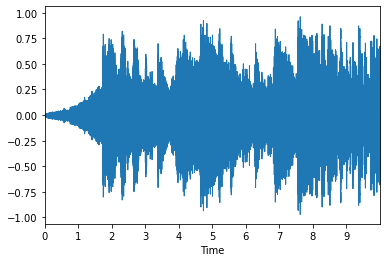

In [ ]:
display.waveplot(seq, sr=SR);

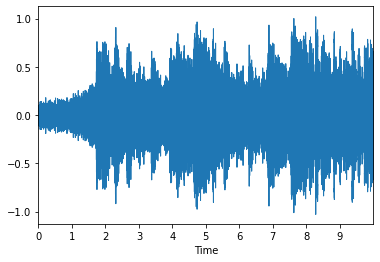

In [ ]:
# add noise
samples = seq.shape[0]
noise = np.random.normal(0,0.05,samples)
seq_n = seq + noise
display.waveplot(seq_n, sr=SR);
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  22400
valid shape =  3200
test shape  =  6400


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=4, batch_size=1, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
22398/22398 [==============================] - 63s 3ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 2/10
22398/22398 [==============================] - 61s 3ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 3/10
22398/22398 [==============================] - 62s 3ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 4/10
22398/22398 [==============================] - 62s 3ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 5/10
22398/22398 [==============================] - 62s 3ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 6/10
22398/22398 [==============================] - 62s 3ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 7/10
22398/22398 [==============================] - 61s 3ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 8/10
22398/22398 [==============================] - 62s 3ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 9/10
22398/22398 [==============================] - 61s 3ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 10/10
22398/22398 [==============================

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1339
valid MSE: 0.1606
test MSE: 0.1517


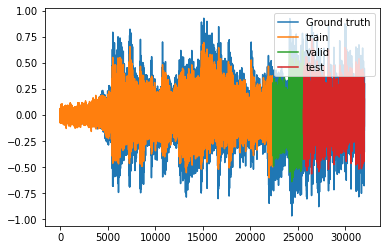

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, SR))

SNR = 1332.8266082347639


In [ ]:
arrays=[
    trainPredict.reshape(-1,),
    validPredict.reshape(-1,),
    testPredict.reshape(-1,)
]

# Create an array to return to
sound_o = np.array([])

for array in arrays:
    sound_o = np.concatenate([sound_o, array])

In [ ]:
Audio(sound_o, rate=SR)

In [ ]:
# save sound
sf.write('sound_out.wav', sound_o, SR, 'PCM_24')

# Picture

In [ ]:
! wget -nc 'https://www.androidauthority.com/wp-content/uploads/2020/04/oneplus-8-pro-ultra-wide-sample-twitter-1.jpg'
! cp 'oneplus-8-pro-ultra-wide-sample-twitter-1.jpg' 'image.jpg'

--2022-01-14 06:11:16--  https://www.androidauthority.com/wp-content/uploads/2020/04/oneplus-8-pro-ultra-wide-sample-twitter-1.jpg
Resolving www.androidauthority.com (www.androidauthority.com)... 141.193.213.11, 141.193.213.10
Connecting to www.androidauthority.com (www.androidauthority.com)|141.193.213.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555593 (543K) [image/jpeg]
Saving to: ‘oneplus-8-pro-ultra-wide-sample-twitter-1.jpg’

oneplus-8-pro-ultra 100%[===================>] 542.57K  --.-KB/s    in 0.04s   

2022-01-14 06:11:17 (12.2 MB/s) - ‘oneplus-8-pro-ultra-wide-sample-twitter-1.jpg’ saved [555593/555593]



## 1-Channel

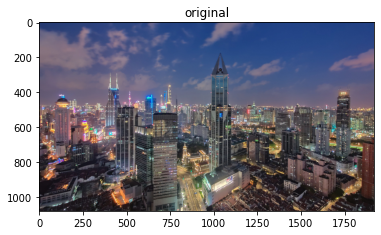

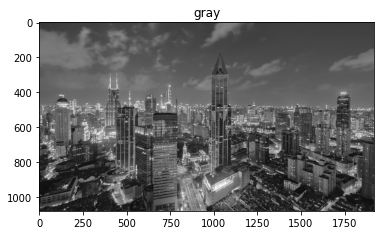

In [ ]:
img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('original')
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img, cmap='gray')
plt.title('gray')
plt.show()

### Train image without noise

In [ ]:
seq_n = img.reshape(-1,)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  1451520
valid shape =  207360
test shape  =  414720


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=256, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/5
5670/5670 [==============================] - 17s 3ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 2/5
5670/5670 [==============================] - 14s 2ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 3/5
5670/5670 [==============================] - 14s 2ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 4/5
5670/5670 [==============================] - 14s 3ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 5/5
5670/5670 [==============================] - 14s 2ms/step - loss: 0.0018 - val_loss: 0.0034



test loss = 0.002446949714794755


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 10.8565
valid MSE: 14.8849
test MSE: 12.6140


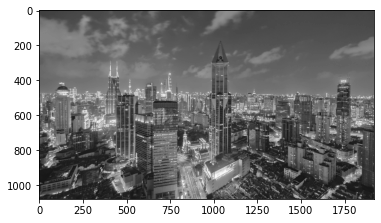

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# show final image
img_final = np.nan_to_num(trainPredictPlot) + np.nan_to_num(validPredictPlot) + np.nan_to_num(testPredictPlot)
img_final = img_final.reshape(img.shape[0], img.shape[1]).astype(np.uint8)
plt.imshow(img_final, cmap='gray')

### Gaussian noise

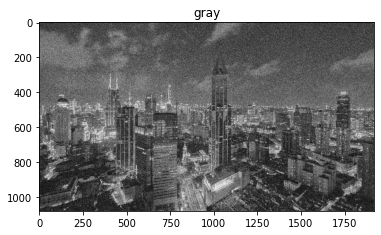

In [ ]:
noise_img = random_noise(img, mode='gaussian', var=0.05)
noise_img = (255*noise_img).astype(np.uint8)

plt.imshow(noise_img, cmap='gray')
plt.title('gray')
plt.show()

In [ ]:
# add noise
seq_n = noise_img.reshape(-1,)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  1451520
valid shape =  207360
test shape  =  414720


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=256, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/5
5670/5670 [==============================] - 19s 3ms/step - loss: 0.0378 - val_loss: 0.0463
Epoch 2/5
5670/5670 [==============================] - 16s 3ms/step - loss: 0.0358 - val_loss: 0.0424
Epoch 3/5
5670/5670 [==============================] - 15s 3ms/step - loss: 0.0324 - val_loss: 0.0409
Epoch 4/5
5670/5670 [==============================] - 15s 3ms/step - loss: 0.0319 - val_loss: 0.0406
Epoch 5/5
5670/5670 [==============================] - 15s 3ms/step - loss: 0.0319 - val_loss: 0.0403



test loss = 0.04340266063809395


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 45.4964
valid MSE: 51.2069
test MSE: 53.1249


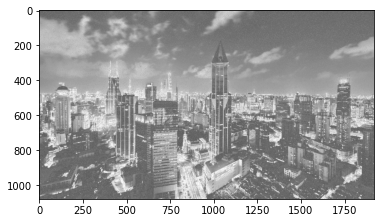

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# show final image
img_final = np.nan_to_num(trainPredictPlot) + np.nan_to_num(validPredictPlot) + np.nan_to_num(testPredictPlot)
img_final = img_final.reshape(img.shape[0], img.shape[1]).astype(np.uint8)
plt.imshow(img_final, cmap='gray')

### Salt and pepper noise

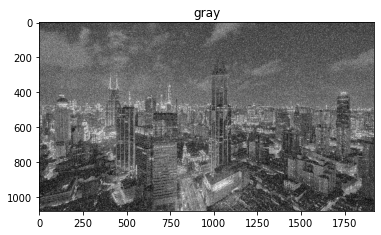

In [ ]:
noise_img = random_noise(img, mode='s&p', amount=0.2)
noise_img = (255*noise_img).astype(np.uint8)

plt.imshow(noise_img, cmap='gray')
plt.title('gray')
plt.show()

In [ ]:
# add noise
seq_n = noise_img.reshape(-1,)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  1451520
valid shape =  207360
test shape  =  414720


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=256, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/5
5670/5670 [==============================] - 18s 3ms/step - loss: 0.0651 - val_loss: 0.0758
Epoch 2/5
5670/5670 [==============================] - 15s 3ms/step - loss: 0.0634 - val_loss: 0.0755
Epoch 3/5
5670/5670 [==============================] - 15s 3ms/step - loss: 0.0610 - val_loss: 0.0707
Epoch 4/5
5670/5670 [==============================] - 16s 3ms/step - loss: 0.0594 - val_loss: 0.0704
Epoch 5/5
5670/5670 [==============================] - 16s 3ms/step - loss: 0.0594 - val_loss: 0.0699



test loss = 0.07511633634567261


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 62.1580
valid MSE: 67.4194
test MSE: 69.8887


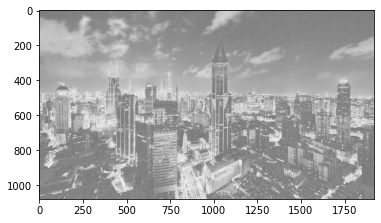

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# show final image
img_final = np.nan_to_num(trainPredictPlot) + np.nan_to_num(validPredictPlot) + np.nan_to_num(testPredictPlot)
img_final = img_final.reshape(img.shape[0], img.shape[1]).astype(np.uint8)
plt.imshow(img_final, cmap='gray')

## 3-Channel

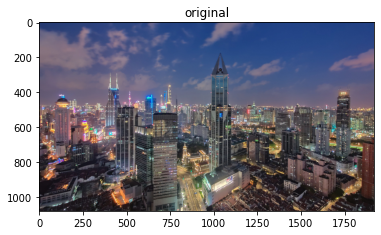

In [ ]:
img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('original')
plt.show()

### Train image without noise

In [ ]:
seq_n = img.reshape(-1,)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  4354560
valid shape =  622080
test shape  =  1244160


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=256, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/5
17010/17010 [==============================] - 52s 3ms/step - loss: 0.0182 - val_loss: 0.0157
Epoch 2/5
17010/17010 [==============================] - 48s 3ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 3/5
17010/17010 [==============================] - 47s 3ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 4/5
17010/17010 [==============================] - 46s 3ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 5/5
17010/17010 [==============================] - 49s 3ms/step - loss: 0.0140 - val_loss: 0.0134



test loss = 0.013142000883817673


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 30.1373
valid MSE: 29.4909
test MSE: 29.2329


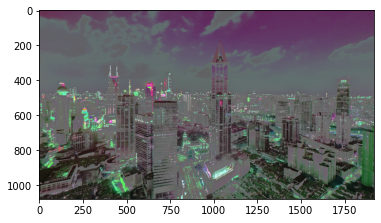

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# show final image
img_final = np.nan_to_num(trainPredictPlot) + np.nan_to_num(validPredictPlot) + np.nan_to_num(testPredictPlot)
img_final = img_final.reshape(img.shape[0], img.shape[1], img.shape[2]).astype(np.uint8)
plt.imshow(img_final)

### Gaussian noise

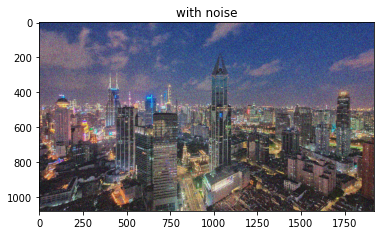

In [ ]:
noise_img = random_noise(img, mode='gaussian', var=0.05)
noise_img = (255*noise_img).astype(np.uint8)

plt.imshow(noise_img)
plt.title('with noise')
plt.show()

In [ ]:
# add noise
seq_n = noise_img.reshape(-1,)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  4354560
valid shape =  622080
test shape  =  1244160


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=256, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/5
17010/17010 [==============================] - 49s 3ms/step - loss: 0.0612 - val_loss: 0.0620
Epoch 2/5
17010/17010 [==============================] - 49s 3ms/step - loss: 0.0606 - val_loss: 0.0637
Epoch 3/5
17010/17010 [==============================] - 49s 3ms/step - loss: 0.0606 - val_loss: 0.0638
Epoch 4/5
17010/17010 [==============================] - 46s 3ms/step - loss: 0.0606 - val_loss: 0.0630
Epoch 5/5
17010/17010 [==============================] - 46s 3ms/step - loss: 0.0605 - val_loss: 0.0626



test loss = 0.06583894789218903


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 62.7140
valid MSE: 63.8046
test MSE: 65.4308


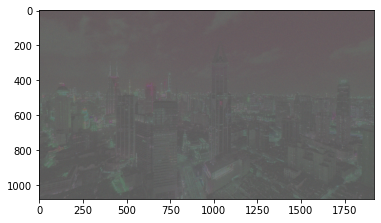

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# show final image
img_final = np.nan_to_num(trainPredictPlot) + np.nan_to_num(validPredictPlot) + np.nan_to_num(testPredictPlot)
img_final = img_final.reshape(img.shape[0], img.shape[1], img.shape[2]).astype(np.uint8)
plt.imshow(img_final)

### Salt and pepper noise

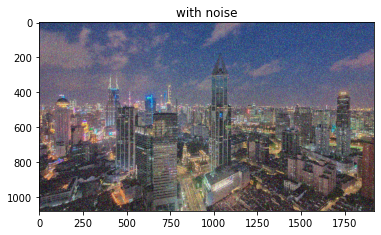

In [ ]:
noise_img = random_noise(img, mode='s&p', amount=0.2)
noise_img = (255*noise_img).astype(np.uint8)

plt.imshow(noise_img)
plt.title('with noise')
plt.show()

In [ ]:
# add noise
seq_n = noise_img.reshape(-1,)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  4354560
valid shape =  622080
test shape  =  1244160


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=256, verbose=1)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/5
17010/17010 [==============================] - 49s 3ms/step - loss: 0.0695 - val_loss: 0.0818
Epoch 2/5
17010/17010 [==============================] - 44s 3ms/step - loss: 0.0689 - val_loss: 0.0814
Epoch 3/5
17010/17010 [==============================] - 47s 3ms/step - loss: 0.0688 - val_loss: 0.0790
Epoch 4/5
17010/17010 [==============================] - 44s 3ms/step - loss: 0.0680 - val_loss: 0.0743
Epoch 5/5
17010/17010 [==============================] - 44s 3ms/step - loss: 0.0673 - val_loss: 0.0746



test loss = 0.07851085811853409


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 66.1556
valid MSE: 69.6647
test MSE: 71.4502


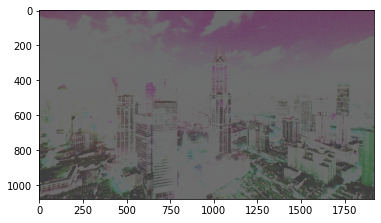

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# show final image
img_final = np.nan_to_num(trainPredictPlot) + np.nan_to_num(validPredictPlot) + np.nan_to_num(testPredictPlot)
img_final = img_final.reshape(img.shape[0], img.shape[1], img.shape[2]).astype(np.uint8)
plt.imshow(img_final)